# Analysis of Toronto Fire Incidents

City of Toronto provides data throgh their [OpenData Poral](https://www.toronto.ca/city-government/data-research-maps/open-data/). In this notebook we examine the [Fire Incidents](https://open.toronto.ca/dataset/fire-incidents/). We also use [fire station locations](https://open.toronto.ca/dataset/fire-station-locations/) and [area maps](https://open.toronto.ca/dataset/toronto-fire-services-run-areas/). 

This is my first Notebook and Dataset. Your feedback is appreciated.

## About Dataset
This dataset provides information similar to what is sent to the Ontario Fire Marshal relating to only fire Incidents to which Toronto Fire responds in more detail than the dataset including all incident types. The Dataset includes only Fire incidents as defined by the Ontario Fire Marshal. For privacy purposes personal information is not provided and exact address have been aggregated to the nearest major or minor intersection. Some incidents have been excluded pursuant to exemptions under Section 8 of Municipal Freedom of Information and Protection of Privacy Act (MFIPPA).

In [1]:
import urllib.request
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import json
from scipy import stats
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import shapefile
%matplotlib notebook

Specify the path to load data

In [2]:
path ='/kaggle/input/toronto-fire-incidents/' 

In [3]:
#helper function to get fire area maps as polygons
def get_firestaion_areas():
    with open(path +  'FIRE_RUN_AREA_WGS84.json', 'r') as f:
        polygons = json.load(f)
    return polygons
#helper function to get fire station locations

def get_firestation_locations():
    with open(path +'FIRE_FACILITY_WGS84.json', 'r') as f:
        facilities = json.load(f)
    fire_stations = np.array(facilities)
    return fire_stations

# helper function to load incident data
def get_fire_incidents_data():
    df = pd.read_csv(path + 'Fire Incidents Data.csv') 
    return df

Let's load the data

In [4]:
# load indicents as pandas data frame
df = get_fire_incidents_data()
# load the area covered by each fire station as a list of polygons
areas = get_firestaion_areas()
# load fire station locatins
stations = get_firestation_locations()

Let's create a data frame for fire incidents and see what data is available

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12687 entries, 0 to 12686
Data columns (total 43 columns):
_id                                                              12687 non-null int64
Area_of_Origin                                                   12687 non-null object
Building_Status                                                  9205 non-null object
Business_Impact                                                  9203 non-null object
Civilian_Casualties                                              12687 non-null int64
Count_of_Persons_Rescued                                         12687 non-null int64
Estimated_Dollar_Loss                                            12686 non-null float64
Estimated_Number_Of_Persons_Displaced                            9204 non-null float64
Exposures                                                        279 non-null float64
Ext_agent_app_or_defer_time                                      12687 non-null object
Extent_Of_Fire            

We will drop columns we don't want to use.

In [6]:

df = df.drop(["Building_Status",\
              "Business_Impact",\
              "Count_of_Persons_Rescued",\
              "Estimated_Number_Of_Persons_Displaced",\
              "Exposures",\
              "Ext_agent_app_or_defer_time",\
              "Extent_Of_Fire",\
              "Final_Incident_Type",\
              "Fire_Alarm_System_Impact_on_Evacuation",\
              "Fire_Alarm_System_Operation",\
              "Fire_Alarm_System_Presence",\
              "Ignition_Source",\
              "Incident_Number",\
              "Incident_Station_Area",\
              "Incident_Ward",\
              "Initial_CAD_Event_Type",\
              "Intersection",\
              "Number_of_responding_apparatus",\
              "Number_of_responding_personnel",\
              "Property_Use",\
              "Smoke_Alarm_at_Fire_Origin",\
              "Smoke_Alarm_at_Fire_Origin_Alarm_Failure",\
              "Smoke_Alarm_at_Fire_Origin_Alarm_Type",\
              "Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation",\
              "Smoke_Spread",\
              "Sprinkler_System_Operation",\
              "Sprinkler_System_Presence", \
              "Status_of_Fire_On_Arrival",\
              "TFS_Firefighter_Casualties",\
              "Level_Of_Origin"], axis=1)



Let's look at a few rows of data.

In [7]:
df.head()

,_id,Area_of_Origin,Civilian_Casualties,Estimated_Dollar_Loss,Fire_Under_Control_Time,Last_TFS_Unit_Clear_Time,Latitude,Longitude,Material_First_Ignited,Method_Of_Fire_Control,Possible_Cause,TFS_Alarm_Time,TFS_Arrival_Time
0,190306,81 - Engine Area,0,1000.0,2015-08-29T12:13:53,2015-08-29T12:40:36,43.72274,-79.59822,16 - Insulation,1 - Extinguished by fire department,51 - Mechanical Failure,2015-08-29T11:52:04,2015-08-29T11:52:19
1,190307,22 - Sleeping Area or Bedroom (inc. patients r...,0,20.0,2017-07-02T21:39:00,2017-07-02T22:33:34,43.69834,-79.51132,99 - Undetermined (formerly 98),3 - Extinguished by occupant,11 - Children Playing (Ages 11 and under),2017-07-02T21:33:06,2017-07-02T21:35:59
2,190308,81 - Engine Area,0,5000.0,2015-02-13T18:48:00,2015-02-13T19:00:02,43.80393,-79.13508,99 - Undetermined (formerly 98),1 - Extinguished by fire department,"28 - Routine maintenance deficiency, eg creoso...",2015-02-13T18:44:29,2015-02-13T18:45:35
3,190309,99 - Undetermined (formerly 98),0,7500.0,2015-02-14T20:26:58,2015-02-14T20:44:37,43.60169,-79.54525,99 - Undetermined (formerly 98),1 - Extinguished by fire department,99 - Undetermined,2015-02-14T20:10:16,2015-02-14T20:13:03
4,190310,81 - Engine Area,0,10000.0,2014-05-26T00:01:06,2014-05-26T00:42:14,43.76462,-79.54708,99 - Undetermined (formerly 98),1 - Extinguished by fire department,99 - Undetermined,2014-05-25T23:44:10,2014-05-25T23:49:51


## Missing Data
Some columns are missing data, we are goig to fill them the best we can. Let's see which datais missing.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12687 entries, 0 to 12686
Data columns (total 13 columns):
_id                         12687 non-null int64
Area_of_Origin              12687 non-null object
Civilian_Casualties         12687 non-null int64
Estimated_Dollar_Loss       12686 non-null float64
Fire_Under_Control_Time     12686 non-null object
Last_TFS_Unit_Clear_Time    12687 non-null object
Latitude                    12686 non-null float64
Longitude                   12686 non-null float64
Material_First_Ignited      12687 non-null object
Method_Of_Fire_Control      12687 non-null object
Possible_Cause              12687 non-null object
TFS_Alarm_Time              12687 non-null object
TFS_Arrival_Time            12687 non-null object
dtypes: float64(3), int64(2), object(8)
memory usage: 1.3+ MB


In [9]:
df['Latitude'] = df['Latitude'].fillna(df['Latitude'].mean())
df['Longitude'] = df['Longitude'].fillna(df['Longitude'].mean())
df['Estimated_Dollar_Loss'] = df['Estimated_Dollar_Loss'].fillna(df['Estimated_Dollar_Loss'].median())
df['Fire_Under_Control_Time'] = df['Fire_Under_Control_Time'].fillna(df['Last_TFS_Unit_Clear_Time'])


Replacing timestamp string with python datetime

In [10]:
def get_date_time_from_str(timestamp_str):
    date_str = timestamp_str[0:timestamp_str.find('T')]
    time_str = timestamp_str[timestamp_str.find('T')+1:]
    [y,m,d] = [int(s) for s in date_str.split('-')]
    [hh,mm,ss] = [int(s) for s in time_str.split(':')]
    return datetime.datetime(y,m,d,hh,mm,ss)

In [11]:
df['TFS_Alarm_Time'] =df["TFS_Alarm_Time"].apply(lambda x: get_date_time_from_str(x))
df['TFS_Arrival_Time'] =df["TFS_Arrival_Time"].apply(lambda x: get_date_time_from_str(x))
df['Fire_Under_Control_Time'] =df["Fire_Under_Control_Time"].apply(lambda x: get_date_time_from_str(x))
df['Last_TFS_Unit_Clear_Time'] =df["Last_TFS_Unit_Clear_Time"].apply(lambda x: get_date_time_from_str(x))

Convert date time to numerical values for processing

In [12]:
df['Day_Of_Week'] = df["TFS_Alarm_Time"].apply(lambda x: x.weekday())
df['Alarm_Time_Min_Of_Day'] = df["TFS_Alarm_Time"].apply(lambda x: x.time().hour * 60 + x.time().minute)
df['Alarm_Time_Hour_OF_Day'] = df["TFS_Alarm_Time"].apply(lambda x: x.time().hour)
df['Alarm_Time_Day_Of_Year'] = df["TFS_Alarm_Time"].apply(lambda x: x.timetuple().tm_yday)
df['Response_Time'] = df.apply(lambda x: (x['TFS_Arrival_Time'] - x['TFS_Alarm_Time']).total_seconds(), axis=1)

# Data Visualization
Let's look at some of the aspects of the data

## Dollor Loss on Map
Latitude, Longitude and dollor loss is available for most of the data. We are going to plot all fire locations and scale the size of each inicident based on dollor loss 

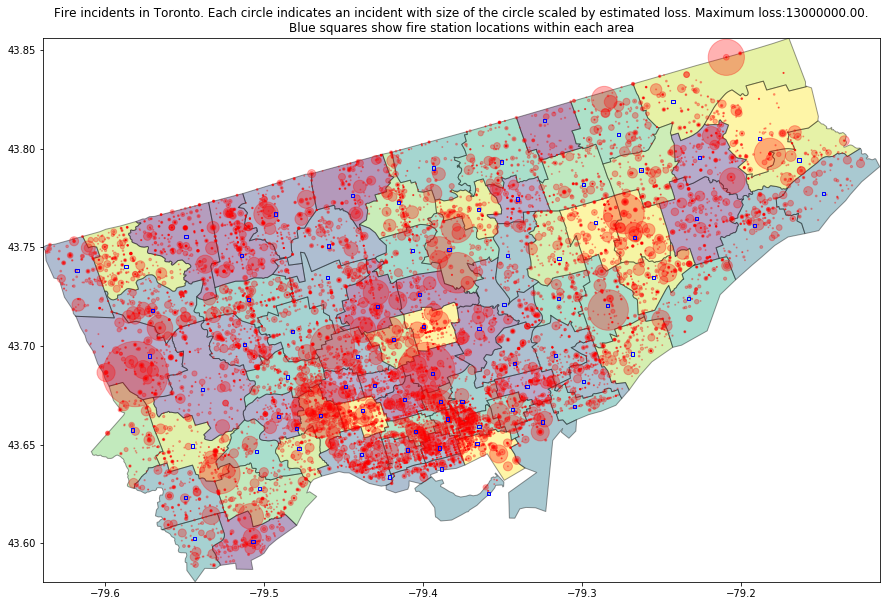

In [13]:

dollor_loss= df['Estimated_Dollar_Loss'].to_numpy()

size = np.clip(10 * dollor_loss / np.mean(dollor_loss),1.0,np.max(dollor_loss))
patches = []

for polygon in areas:
    polygon_patch = Polygon(polygon, True)
    patches.append(polygon_patch)


colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.4,edgecolor = 'k')
fig, ax = plt.subplots(figsize=(15, 10))
p.set_array(np.array(colors))
ax.add_collection(p)
ax.set_title('Fire incidents in Toronto. Each circle indicates an incident with size of \
the circle scaled by estimated loss. Maximum loss:%.2f.\nBlue squares show fire station locations within each area'%dollor_loss.max())
plt.autoscale(tight=True)
plt.scatter(df['Longitude'], df['Latitude'] , s=size, c ='r', alpha=0.3, marker = 'o')
plt.scatter(stations[:,0], stations[:,1] , marker = 's', s = 10, facecolors='none', edgecolors='b')

plt.show()


Here we see the histogram of dollor loss:

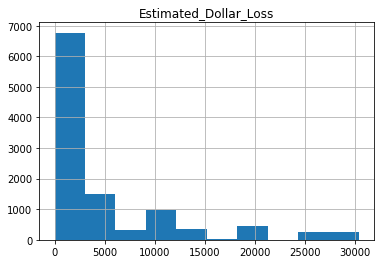

In [14]:
max_dollor_loss = np.max(dollor_loss)
std_dollor_loss =np.std(dollor_loss)
hist_low = 0
hist_high = int( np.mean(dollor_loss))
bins = range(hist_low,hist_high, (hist_high - hist_low)//10)

h = df.hist(column = [ 'Estimated_Dollar_Loss'], bins=bins)

## Civilian Casualties on map
Let's plot the number of casualties 

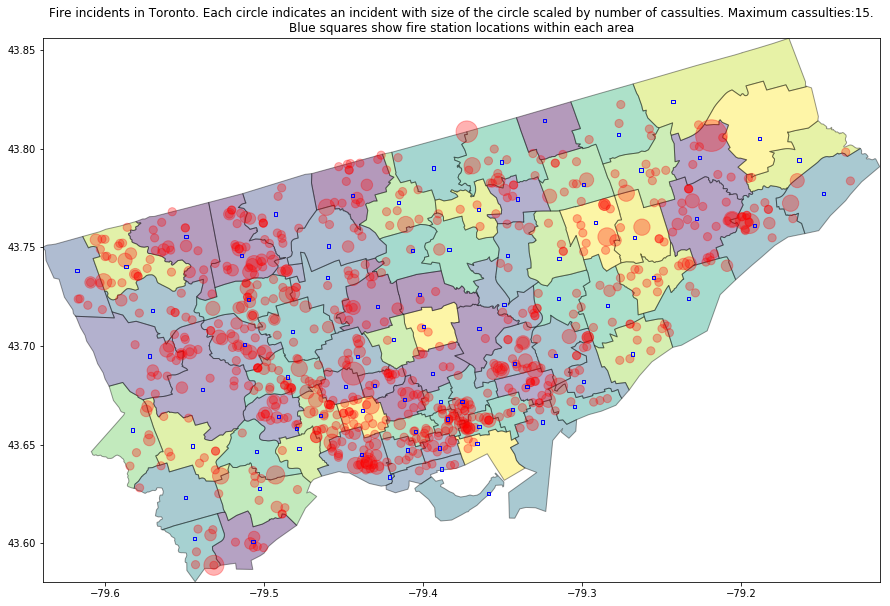

In [15]:
cassulties= df['Civilian_Casualties'].to_numpy().astype(float)
size = 1000 * cassulties/np.max(cassulties)

patches = []

for polygon in areas:
    polygon_patch = Polygon(polygon, True)
    patches.append(polygon_patch)


p = PatchCollection(patches, alpha=0.4, edgecolor = 'k')
fig, ax = plt.subplots(figsize=(15, 10))
p.set_array(np.array(colors))
ax.add_collection(p)
ax.set_title('Fire incidents in Toronto. Each circle indicates an incident with size of \
the circle scaled by number of cassulties. Maximum cassulties:%d.\nBlue squares show fire station locations within each area'\
%df['Civilian_Casualties'].max())
plt.autoscale(tight=True)
plt.scatter(df['Longitude'], df['Latitude'], s= size,c='r', alpha=0.3, marker = 'o')
plt.scatter(stations[:,0], stations[:,1] , marker = 's', s = 10, facecolors='none', edgecolors='b')
plt.show()


## Fire incident analysis
In this section we look at data we have regarding the incident itself. We look at 4 properties of the fire and draw pie charts based on number of occurances of. The properties are: Area_of_Origin, Material_First_Ignited, Possible_Cause, Method_Of_Fire_Control. 


In [16]:
# There a few columns such as 'Area_of_Origin' where data is specified with a code and 
# tag. such as :'81 - Engine Area'. Tis helper function returns most occured code/tag for
# a column
def get_top_from_list(df,column, size = 10):
    column_values =  df[column]
#     create to dictionaries to keep tags and count
    column_values_tags ={}
    column_values_count ={}
# for all values in column split code from tag
    for a in column_values:
        split = a.split('-')

        code = int(split[0])
        tag = split[1]

        if not code in column_values_count:
            column_values_count[code] = 0
        else:
            column_values_count[code]+=1

        if not code in column_values_tags:
            column_values_tags[code] = tag
        elif  column_values_tags[code] != tag:
            print("warning mismatch tag and code")  
# convert dictionaries to list
    tag_count = []
    keys = list(column_values_tags.keys())
    for k in keys:
        count = column_values_count[k]
        tag = column_values_tags[k] + ' :'+ str(count)
        tag_count.append([count, tag])
    count_np = np.array(column_values_count)

    tag_count.sort(reverse = True)
    
    if size < len(tag_count):
        sum_rest = 0
        for a in tag_count[size:]:
            sum_rest += a[0]
        del tag_count[size:]
        tag_count.append([sum_rest, 'others :'+ str(sum_rest)])

    counts = []
    tags = []
    for tc in tag_count:
        counts.append(tc[0])
        tags.append(tc[1])

    return counts, tags

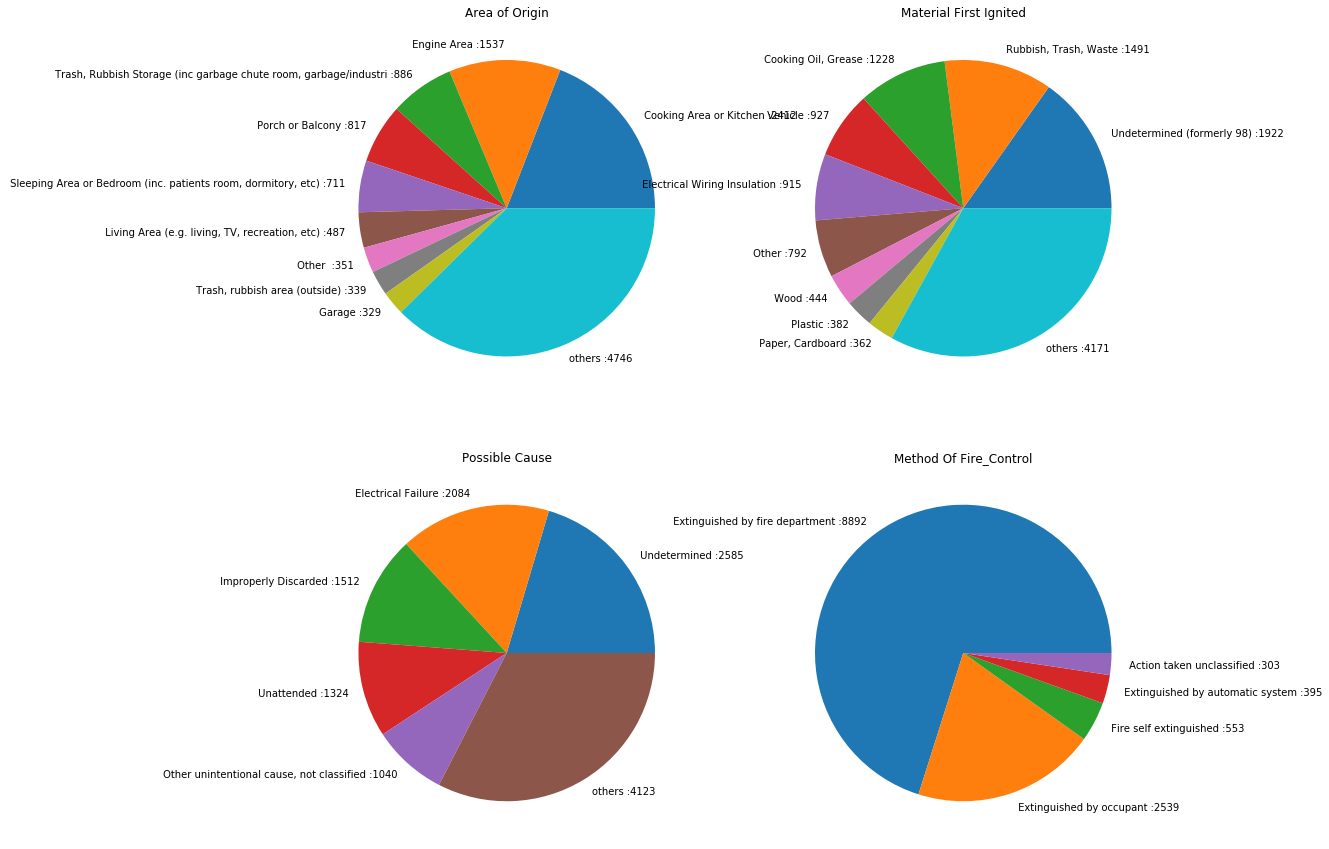

In [17]:
# Area_of_Origin
area_of_origin_count, area_of_origin_tags = get_top_from_list(df,'Area_of_Origin',9)
material_count, material_tags = get_top_from_list(df,'Material_First_Ignited',9)
cause_count, cause_tags = get_top_from_list(df,'Possible_Cause',5)
method_count, method_tags = get_top_from_list(df,'Method_Of_Fire_Control',5)


fig, ax = plt.subplots(figsize=(15, 15))
plt.subplot(2,2,1)
plt.pie(area_of_origin_count,  labels=area_of_origin_tags)
plt.title('Area of Origin')

plt.subplot(2,2,2)
plt.pie(material_count,  labels=material_tags)
plt.title('Material First Ignited')

plt.subplot(2,2,3)
plt.pie(cause_count,  labels=cause_tags)
plt.title('Possible Cause')

plt.subplot(2,2,4)
plt.pie(method_count,  labels=method_tags)
plt.title('Method Of Fire_Control')

plt.show()


# Response Time Analysis:
In this section we study factors that affect reponse time. Which is defined as the duration between when a 911 call is made to first responders arrive at the scene

We are going to create another data frame "df_time" where we put all data needed for time analysis

In [18]:
df_time =df[['Response_Time', 'Latitude','Longitude', 'Alarm_Time_Min_Of_Day', 'Alarm_Time_Day_Of_Year','Day_Of_Week']]



We are going to remove outliers using z_score to remove outliers

In [19]:
z_score = np.abs(stats.zscore(df_time))
df_time = df_time[(z_score < 2.5).all(axis=1)]
num_data_removed =  len(df)-len(df_time)
print("removed %d outliers from total of %d records"%(num_data_removed,len(df)))


removed 47 outliers from total of 12687 records


l=Let's look at how response time changes based on, time in day, date and day of week

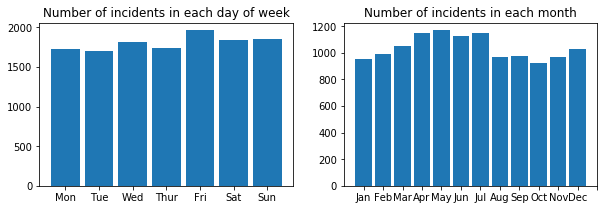

In [20]:
fig, ax = plt.subplots(figsize=(10, 3))

plt.subplot(1,2,1)
plt.hist(df_time['Day_Of_Week'], bins=np.arange(-.5,7.,1.0),  rwidth=0.85)
plt.xticks(np.arange(7), ('Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat','Sun'))
plt.title('Number of incidents in each day of week')
plt.subplot(1,2,2)
bins=np.arange(-.5,365,30)
plt.hist(df_time['Alarm_Time_Day_Of_Year'],  bins=bins, align= 'left', rwidth=0.85)
plt.xticks(bins, ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul','Aug','Sep','Oct','Nov','Dec',''))
plt.title('Number of incidents in each month')

plt.show()



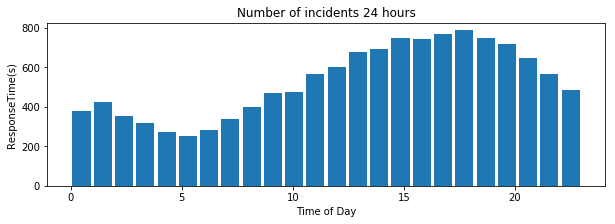

In [21]:
fig, ax = plt.subplots(figsize=(10, 3))
s=np.arange(-.5,24)
plt.hist(df['Alarm_Time_Hour_OF_Day'], bins = 24, rwidth=0.85)
plt.title('Number of incidents 24 hours')
plt.xlabel('Time of Day')
plt.ylabel('ResponseTime(s)')

plt.show()

## Response time based on location

we are going to plot average response time on the map and see how response time changes based on where the incident happened

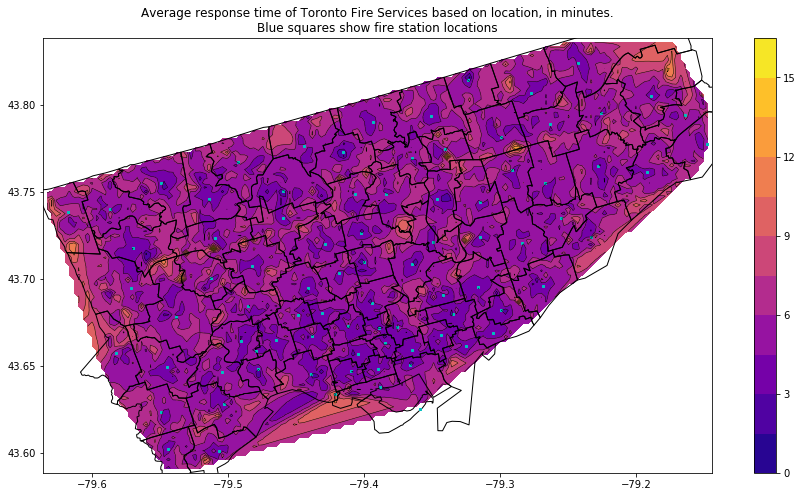

In [22]:
import matplotlib.tri as tri
# -----------------------
# Interpolation on a grid
# -----------------------
# A contour plot of irregularly spaced data coordinates
# via interpolation on a grid.
ngridx = 150
ngridy = 100
# Create grid values first.
xi = np.linspace(df_time['Longitude'].min(),df_time['Longitude'].max(), ngridx)
yi = np.linspace(df_time['Latitude'].min(), df_time['Latitude'].max(), ngridy)

x = df_time['Longitude']
y = df_time['Latitude']
z = df_time['Response_Time']
fig, ax = plt.subplots(figsize=(15,8))


triang = tri.Triangulation(x,y)
interpolator = tri.LinearTriInterpolator(triang, z/60)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)
ax.contour(xi, yi, zi, levels=10, linewidths=0.5, colors='k')
cntr1 = ax.contourf(xi, yi, zi, levels=10, cmap="plasma")

fig.colorbar(cntr1, ax=ax)
ax.set(xlim=(df_time['Longitude'].min(),df_time['Longitude'].max()),\
        ylim=(df_time['Latitude'].min(), df_time['Latitude'].max()))
ax.set_title('Average response time of Toronto Fire Services based on location, in minutes.\
\nBlue squares show fire station locations')


# draw fire station area map
patches = []

for polygon in areas:
    polygon_patch = Polygon(polygon)
    patches.append(polygon_patch)


p = PatchCollection(patches,facecolor = '',edgecolor = 'k' , linewidths=1.0)
ax.add_collection(p)
plt.scatter(stations[:,0], stations[:,1] , marker = 's', c='c', s = 5.0)

plt.show()


# Response time Estimation
in this section we try to predict how long is it going take for Toronto Fire Service to arrive after a call is made.
Here are the features we considered **Latitude, Longitude, Alarm_Time_Min_Of_Day, Alarm_Time_Day_Of_Year, Day_Of_Week**

Let's prepare the data

In [23]:
from sklearn.model_selection import train_test_split
data_x = df_time[['Latitude','Longitude', 'Alarm_Time_Min_Of_Day', 'Alarm_Time_Day_Of_Year','Day_Of_Week']]
data_y = df_time[['Response_Time']]

# setup normalization
from sklearn.preprocessing import MinMaxScaler
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()


x_scaler.fit(data_x)
y_scaler.fit(data_y)

data_x_scaled = x_scaler.transform(data_x)
data_y_scaled = y_scaler.transform(data_y)

data_y_scaled = np.ravel(data_y_scaled)
# Split data to train/test
train_x, test_x, train_y, test_y = train_test_split(data_x_scaled, data_y_scaled, test_size=0.1, random_state=42)



In [24]:
#helper function to evaluate a model
from sklearn.metrics import mean_squared_error
def evaluate_model(model, model_name = None):
    model.fit(train_x,train_y)
    pred = model.predict(test_x)
    error = mean_squared_error(test_y, pred)
    if model_name is not None:
        print("Error for %s, : %.6f"%(model_name, error))
    return error


1. In this section we evaluate some regression methods

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import neighbors
from sklearn import tree
from sklearn import svm
models =[LinearRegression(),linear_model.Ridge(),\
         neighbors.KNeighborsRegressor(5,weights='uniform'), linear_model.BayesianRidge(),\
         tree.DecisionTreeRegressor(max_depth=4),svm.SVR(gamma = 'auto')]
tags = ["inearRegression","Ridge", 'knn5', "BayesianRidge", 'tree4','svr']
for model,tag in zip(models,tags):
    error = evaluate_model(model,tag)

Error for inearRegression, : 0.005054
Error for Ridge, : 0.005054
Error for knn5, : 0.005863
Error for BayesianRidge, : 0.005054
Error for tree4, : 0.004829
Error for svr, : 0.005071
